# <span style="color: #ff6D04; font-weight: bold;font-size: 75px;">MLflow + FiftyOne Workflow</span>


# <span style="color: #212529; font-weight: bold;font-size: 55px;">A Guided Walkthrough</span>


## <span style="color: #A6a7a9; font-weight: 500;font-size: 30px;">Installing Requirements</span>

<span style="color: #212529; font-weight: 500;font-size: 20px;">First install the required python libraries below</span>

In [ ]:
!pip install mlflow fiftyone torch torchvision

<span style="color: #212529; font-weight: 500;font-size: 20px;">Next we will install the fiftyone-mlflow-plugin that will allow us to view and manage our MLflow client in the FiftyOne App!</span>

In [ ]:
!fiftyone plugins download https://github.com/jacobmarks/fiftyone_mlflow_plugin

## <span style="color: #A6a7a9; font-weight: 500;font-size: 30px;">Prepping for Training</span>

<span style="color: #212529; font-weight: 500;font-size: 20px;">Let's kick things off by loading in all of our required libraries. While we are at it, we will start our MLflow client and specifying our `tracking_uri`</span>

In [1]:
import json
from bson import json_util
import sys
import os


import mlflow
from mlflow import MlflowClient
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.operators as foo
import fiftyone.plugins as fop
import fiftyone.brain as fob
import fiftyone.utils.random as four

from fiftyone import ViewField as F


In [2]:
package_directory = os.path.dirname(fop.find_plugin("@jacobmarks/mlflow_tracking"))
if package_directory not in sys.path:
    sys.path.append(package_directory)
from fiftyone_mlflow_plugin import log_mlflow_run_to_fiftyone_dataset

<span style="color: #212529; font-weight: 500;font-size: 20px;">For our example workflow, I will be using a subset of the <a href="https://github.com/VisDrone/VisDrone-Dataset?tab=readme-ov-file">VisDrone</a> dataset, a state of the art drone imagery dataset from  Lab of Machine Learning and Data Mining, Tianjin University, China. It features a wide range of locations, time of day, objects, and angles. The subset we will be using can be downloaded on <a href="https://drive.google.com/file/d/1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn/view">Google Drive</a>. Once the file is downloaded and unzipped, we can load it in by following our ingestor below!</span>

In [3]:
import os
import pandas as pd

dataset_dir="./VisDrone-train/VisDrone2019-DET-train/images"
name = "VisDrone"

# Create the dataset by loading in the directory of images
dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=fo.types.ImageDirectory,
    name=name,
    overwrite=True
)

# We compute the metadata of the dataset to get height and width of all our samples
dataset.compute_metadata()

 100% |███████████████| 6471/6471 [452.5ms elapsed, 0s remaining, 14.3K samples/s]      
Computing metadata...
 100% |███████████████| 6471/6471 [1.0s elapsed, 0s remaining, 6.4K samples/s]         


<span style="color: #212529; font-weight: 500;font-size: 20px;">VisDrone features 12 different classes which we will create a dictionary for. The annotations are stored as <x, y, w, h, confidence, label, truncation, occlusion> in txt files. Since it is a custom format, we ingest it by looping through our datasets and grabbing each sample. Next we open up the text file and add the detections and all their metadata on a sample by sample basis</span>

In [4]:
class_map = {0:"ignore_regions",
             1:"pedestrians",
             2:"people",
             3:"bicycle",
             4:"car",
             5:"van",
             6:"truck",
             7:"tricycle",
             8:"awning_tricycle",
             9:"bus",
             10:"motor",
             11:"others",
}

ann_dir = "./VisDrone-train/VisDrone2019-DET-train/annotations/"

for sample in dataset:

    # Grab the annotation file
    filename = os.path.basename(sample.filepath)
    ann = ann_dir + os.path.splitext(filename)[0] + ".txt"
    if os.path.exists(ann):
        with open(ann, 'r') as file:
            detections = []
            for line in file:
                split_line = line.strip().split(",")
                ann_list = [int(x) for x in split_line[:8]]

                # Grab all the detection information from the line
                label = class_map[ann_list[5]]
                trunc = ann_list[6]
                occ = ann_list[7]

                # FiftyOne takes in normalized (x,y,w,h) bounding boxes
                x = ann_list[0] / sample.metadata.width
                y = ann_list[1] / sample.metadata.height
                w = ann_list[2] / sample.metadata.width
                h = ann_list[3] / sample.metadata.height
                det = fo.Detection(
                    label=label,
                    bounding_box = [x,y,w,h],
                    truncation=trunc,
                    occlusion=occ
                )
                detections.append(det)

            sample["ground_truth"] = fo.Detections(detections=detections)
            sample.save()

# Set our dataset as persistent
dataset.persistent=True

<span style="color: #212529; font-weight: 500;font-size: 20px;">After loading both our images and annotations in, we set the dataset as persistent to have it persist in the database and make sure any new changes will saved. This also allows for easy reloading on future sessions with the following: </span>

In [3]:
dataset = fo.load_dataset("VisDrone")

<span style="color: #212529; font-weight: 500;font-size: 20px;">Finally, we can launch our FiftyOne app with the line below to visualize our dataset: </span>


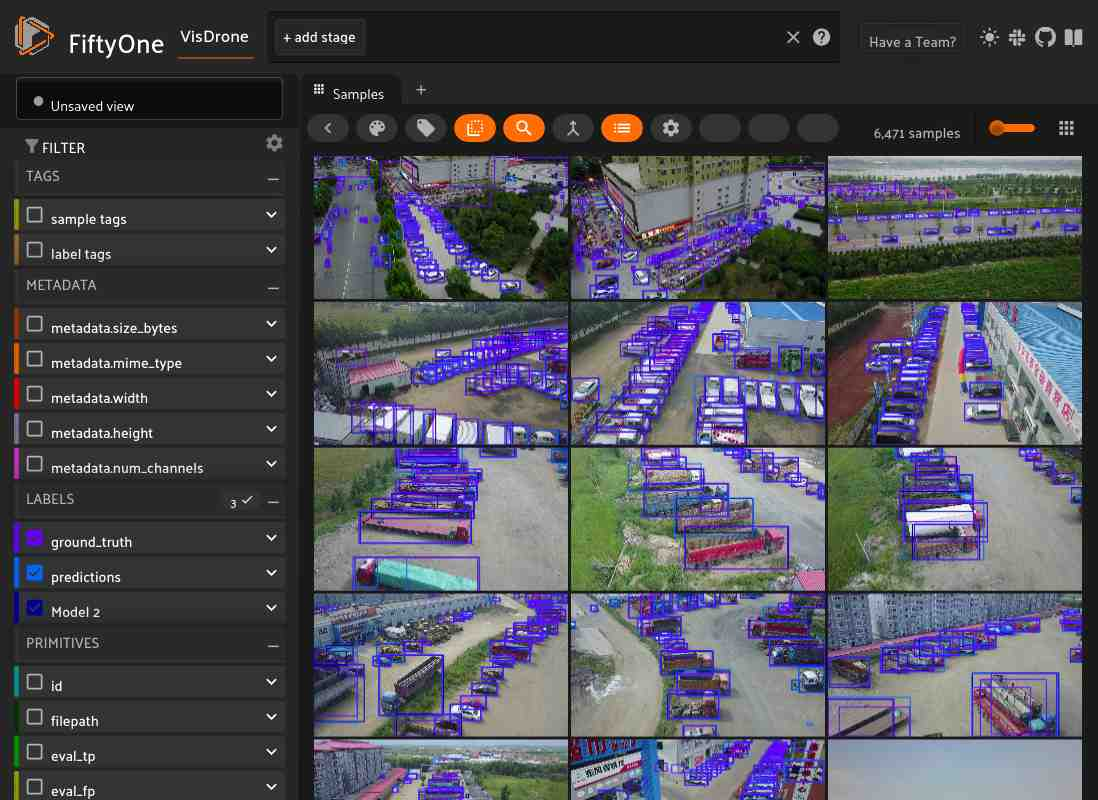

In [4]:
session = fo.launch_app(dataset)

<span style="color: #212529; font-weight: 500;font-size: 20px;">At this point, we can begin the data curation process and begin to look for issues or mistakes in our datasets. We can leverage powerful features within FiftyOne to help bring new insights into our dataset and create high quality subsets of our data to train on.</span>

- [Visualize embeddings with FiftyOne Brain](https://docs.voxel51.com/user_guide/brain.html#visualizing-embeddings)
- [Search your datasets with text prompts or sort by similarity](https://docs.voxel51.com/user_guide/brain.html#similarity)
- [Find image quality issues](https://github.com/jacobmarks/image-quality-issues)
- [Find exact and approximate duplicates](https://github.com/jacobmarks/image-deduplication-plugin)
- [Find outliers in your dataset](https://github.com/danielgural/outlier_detection)
- [Create interesting views of your dataset by filtering, slicing, sorting, and more!](https://docs.voxel51.com/user_guide/using_views.html)

<span style="color: #212529; font-weight: 500;font-size: 20px;">All these curation tools, the MLFlow panel and more are powered by <a href="https://github.com/voxel51/fiftyone-plugins">FiftyOne Plugins</a>!</span>

<span style="color: #212529; font-weight: 500;font-size: 20px;">Once you have created a view you like, we need to export the dataset in YOLO format in order to train YOLO9. We do so by randomly splitting and using the `export` method</a>:</span>

In [22]:
class_map = {0:"ignore_regions",
             1:"pedestrians",
             2:"people",
             3:"bicycle",
             4:"car",
             5:"van",
             6:"truck",
             7:"tricycle",
             8:"awning_tricycle",
             9:"bus",
             10:"motor",
             11:"others",
}

# Replace below with you own saved view, or use the whole dataset
#curated = dataset.load_saved_view("Curated")
curated = dataset

four.random_split(curated, {"val": 0.15, "train": 0.85})
classes = list(class_map.values())

for split in ["val","train","test"]:
    view =  curated.match_tags(split)
    view.export(
        export_dir="VisDrone_curated/",
        split=split,
        dataset_type=fo.types.YOLOv5Dataset,
        classes=classes
    )


 100% |███████████████| 1779/1779 [12.3s elapsed, 0s remaining, 126.8 samples/s]      
Directory 'VisDrone_curated/' already exists; export will be merged with existing files
 100% |███████████████| 6308/6308 [43.9s elapsed, 0s remaining, 91.8 samples/s]       
Directory 'VisDrone_curated/' already exists; export will be merged with existing files
 100% |█████████████████████| 0/0 [6.2ms elapsed, ? remaining, ? samples/s] 


## <span style="color: #A6a7a9; font-weight: sem-bold;font-size: 30px;">Beginning Training</span>

### <span style="color: #212529; font-weight: 500;font-size: 20px;">We will be training the brand new Yolov9 model for this example! I have created a fork of the <a href="https://github.com/WongKinYiu/yolov9">orignal repo</a> that has MLFlow and FiftyOne hooks added in the appropriate spots. Below are steps to clone and install the required packages:</span>

In [ ]:
!git clone https://github.com/danielgural/yolov9_mlflow.git

# apt install required packages
#apt update
#apt install -y zip htop screen libgl1-mesa-glx

# pip install required packages
!pip install seaborn thop


In [10]:
os.path.abspath("yolov9_mlflow")

'/home/dan/Documents/databricks/yolov9_mlflow'

In [11]:
package_directory = os.path.abspath("yolov9_mlflow")
if package_directory not in sys.path:
    sys.path.append(package_directory)

<span style="color: #212529; font-weight: 500;font-size: 20px;">The weights of the pretrained model are not available in the repo yet so we need to download them:</span>

In [35]:
!mkdir ./yolov9_mlflow/weights
!wget -P ./yolov9_mlflow/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P ./yolov9_mlflow/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt

### <span style="color: #212529; font-weight: 500;font-size: 20px;">Below we define some helper functions before we start, feel free to take a look!</span>

In [7]:
def serialize_view(view):
    return json.loads(json_util.dumps(view._serialize()))


In [8]:
def experiment_exists(experiment_name):
    return mlflow.get_experiment_by_name(experiment_name) is not None

In [9]:
def create_fiftyone_mlflow_experiment(
    experiment_name, sample_collection, experiment_description=None
):
    """
    Create a new MLflow experiment for a FiftyOne sample collection.

    Args:
    - experiment_name: The name of the MLflow experiment to create
    - sample_collection: A FiftyOne sample collection to use as the dataset for the experiment
    - experiment_description: An optional description for the MLflow experiment
    """

    tags = {
        "mlflow.note.content": experiment_description,
        "dataset": sample_collection._dataset.name,
    }
    client.create_experiment(name=experiment_name, tags=tags)

In [10]:
import yaml

def load_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            yaml_data = yaml.safe_load(file)
            return yaml_data
        except yaml.YAMLError as e:
            print("Error loading YAML:", e)
            return None

# Example usage of loading hyperparameter yaml:
file_path = 'yolov9_mlflow/data/hyps/hyp.scratch-high.yaml'  # Replace this with the path to your YAML file
data = load_yaml_file(file_path)
print(data)

{'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 7.5, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 0.7, 'obj_pw': 1.0, 'dfl': 1.5, 'iou_t': 0.2, 'anchor_t': 5.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.9, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.15, 'copy_paste': 0.3}


### <span style="color: #212529; font-weight: 500;font-size: 20px;">Below we define our core `run_fiftyone_mlflow_experiment` function. This will allow us to pass in our FiftyOne dataset or view and begin a training run. The run will be stored on MLFlow with information of the hyperparameters, dataset contents, and metrics during training like mAP score! A custom run will also be saved to the FiftyOne dataset that saves information like the tracking_uri and experiment name from MLFlow! </span>

In [14]:
def run_fiftyone_mlflow_experiment(
    sample_collection,
    training_func,
    experiment_name,
    experiment_description="",
):
    """
    Run an MLFlow experiment on a FiftyOne sample collection using the provided model and training function.

    Args:
    - sample_collection: A FiftyOne sample collection to use as the dataset for the experiment
    - model: A model to train and log metrics for
    - training_func: A function that trains the model and returns it
    - experiment_name: The name of the MLflow experiment to create
    - experiment_description: An optional description for the MLflow experiment
    - apply_model_func: An optional function that applies the model to the sample collection
    - add_predictions: Whether to add the model's predictions for the sample collection
    """

    if not experiment_exists(experiment_name):
        create_fiftyone_mlflow_experiment(
            experiment_name, sample_collection, experiment_description
        )

    mlflow.set_experiment(experiment_name)
    
    # Train the model
    with mlflow.start_run() as run:

        log_mlflow_run_to_fiftyone_dataset(sample_collection, experiment_name, run_id=run.info.run_id)
        
        if sample_collection._dataset != sample_collection:
            ## log the serialized `DatasetView`
            mlflow.log_param("dataset_view", serialize_view(sample_collection))


        # Change to your own custom hyperparameter yaml or pass individual values into the training function below
        hyp_path = 'yolov9_mlflow/data/hyps/hyp.scratch-high.yaml'

        hyp = load_yaml_file('yolov9_mlflow/data/hyps/hyp.scratch-high.yaml')

        mlflow.log_params(hyp)

        print(experiment_name)

        # Start training
        training_func(mlflow,
                  data="./VisDrone_curated/dataset.yaml",
                  hyp=hyp_path,
                  imgsz=640,
                  weights="yolov9_mlflow/weights/yolov9-c.pt",
                  cfg="yolov9_mlflow/models/detect/yolov9-c.yaml",
                  batch_size=4,
                  epochs=25,
                  name=experiment_name,
                  exist_ok=False)


                         
        mlflow.log_artifact("yolov9_mlflow4/runs/train/"+experiment_name+"/weights/best.pt")
        mlflow.log_artifact("yolov9_mlflow4/runs/train/"+experiment_name+"/hyp.yaml")
        mlflow.log_artifact("yolov9_mlflow4/runs/train/"+experiment_name+"/opt.yaml")

        

        



<span style="color: #212529; font-weight: 500;font-size: 20px;">To begin, we pass in our dataset or view, our training function, and the name of the experiment </span>

In [ ]:
import yolov9_mlflow.fo_mlflow_train as train

run_fiftyone_mlflow_experiment(dataset,
                               train.run,
                               "mlflow_fiftyone",
                              )

<span style="color: #212529; font-weight: 500;font-size: 20px;">During our run, we can monitor its status in the FiftyOne App through the MLFlow panel: </span>

<img src="./assets/mlflow.gif" alt="MLFLow Monitoring">

## <span style="color: #A6a7a9; font-weight: 500;font-size: 30px;">Adding Predictions to Our Dataset</span>

### <span style="color: #212529; font-weight: 500;font-size: 20px;">We define a `scale_bounding_boxes` helper function below:</span>

In [5]:
def scale_bounding_boxes(bounding_boxes, from_shape, to_shape):
    """
    Scale bounding boxes from one image shape to another.

    Parameters:
    - bounding_boxes: A list of bounding boxes where each bounding box is represented as [x1, y1, x2, y2].
    - from_shape: The original shape of the image (height, width).
    - to_shape: The target shape of the image (height, width).

    Returns:
    - scaled_bounding_boxes: A list of scaled bounding boxes in the new image shape.
    """

    # Unpack the shapes
    from_height, from_width = from_shape
    to_height, to_width = to_shape

    # Calculate scaling factors
    scale_x = to_width / from_width
    scale_y = to_height / from_height

    # Scale each bounding box
    scaled_bounding_boxes = []
    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        scaled_x1 = int(x1 * scale_x) / to_width
        scaled_y1 = int(y1 * scale_y) / to_height
        scaled_w = int(x2 * scale_x)  / to_width - scaled_x1
        scaled_h = int(y2 * scale_y)  / to_height - scaled_y1
        scaled_bounding_boxes.append([scaled_x1, scaled_y1, scaled_w, scaled_h])

    return scaled_bounding_boxes


### <span style="color: #212529; font-weight: 500;font-size: 20px;">To begin adding predictions to our dataset, we load in our model with the code below:</span>

In [12]:
from yolov9_mlflow.models.common import DetectMultiBackend
import torch

model = DetectMultiBackend("./yolov9_mlflow/runs/train/mlflow_fiftyone4/weights/best.pt", device=torch.device("cuda:0"), dnn=False, data="./VisDrone_YOLO/dataset.yaml", fp16=False)

Fusing layers... 
yolov9-c summary: 604 layers, 50723688 parameters, 0 gradients, 236.8 GFLOPs


### <span style="color: #212529; font-weight: 500;font-size: 20px;">Define the class map if you haven't already</span>

In [13]:
class_map = {0:"ignore_regions",
             1:"pedestrians",
             2:"people",
             3:"bicycle",
             4:"car",
             5:"van",
             6:"truck",
             7:"tricycle",
             8:"awning_tricycle",
             9:"bus",
             10:"motor",
             11:"others",
}


### <span style="color: #212529; font-weight: 500;font-size: 20px;">Below, we create a loop over our dataset where our model will inference each sample. We then take each prediction and perform NMS. Afterwards, they are added to a new label field on our dataset.</span>

In [14]:
from PIL import Image
import numpy as np
import torch.nn.functional as TF
from yolov9_mlflow.yolo_utils.general import non_max_suppression

# Loop over every sample
for sample in dataset:

    # Load the image and preprocess it
    im = Image.open(sample.filepath)
    im0 = np.transpose(np.array(im), (2,0,1))
    im = torch.from_numpy(im0).to(model.device)
    im = im.half() if model.fp16 else im.float()
    im = TF.interpolate(im.unsqueeze(0), size=(640, 640), mode='bilinear', align_corners=False)
    im /= 255

    # Inference on the image
    pred = model(im, augment=False, visualize=False)

    # Perform NMS on the predictions
    conf_thres=0.25  # confidence threshold
    iou_thres=0.45  # NMS IOU threshold
    classes = None
    agnostic_nms = False
    max_det = 1000
    
    out_boxes = non_max_suppression(pred[0], conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    out_boxes = out_boxes[0].cpu().numpy()

    # Add our new boxes to our FiftyOne sample
    if len(out_boxes) > 0:
        boxes = out_boxes[:,:4]
    
        
        reformed_boxes = scale_bounding_boxes(boxes,tuple(im.shape[2:]),  im0.shape[1:])
    
        final_boxes = np.concatenate((reformed_boxes, out_boxes[:,4:]), axis=1)
    
        detections = []
        for box in final_boxes:
            det = fo.Detection(
                    label=class_map[box[5]],
                    bounding_box=[box[0],box[1],box[2],box[3]],
                    confidence=box[4],
            )
            detections.append(det)
        sample["predictions"] = fo.Detections(detections=detections)
        sample.save()


### <span style="color: #212529; font-weight: 500;font-size: 20px;">Finally, let's view our dataset again!</span>

In [ ]:
session.dataset = dataset

## <span style="color: #A6a7a9; font-weight: 500;font-size: 30px;">Evaluating Our Models</span>

### <span style="color: #212529; font-weight: 500;font-size: 20px;">We can use `evaluate_detections` and calculate the mAP of our model. We also add metadata to our sample detections such if they were a false potive or a true positive!</span>

In [17]:
results = dataset.evaluate_detections(pred_field="Model 2", gt_field="ground_truth", eval_key="eval2", compute_mAP=True)

Evaluating detections...
 100% |███████████████| 6471/6471 [20.0m elapsed, 0s remaining, 6.6 samples/s]      
Performing IoU sweep...
 100% |███████████████| 6471/6471 [6.8m elapsed, 0s remaining, 14.2 samples/s]      


### <span style="color: #212529; font-weight: 500;font-size: 20px;">We can repeat the workflow of adding predictions and evaluating for any number of models on our dataset! You can even compare predicitions from one model to another using the <a href=https://github.com/allenleetc/model-comparison>model comparision</a> plugin!</span>

<img src="./assets/model_compare_input.gif" alt="Model Compare Input">

### <span style="color: #212529; font-weight: 500;font-size: 20px;">We can choose from a variety of options to see exactly where your two models differ. Forget searching across hundreds of thousands of detection, the model comparision plugin will bring only the samples of interest right in front of you! </span>

<img src="./assets/model_compare_out.gif" alt="Model Compare Input">

### <span style="color: #212529; font-weight: 500;font-size: 20px;">A trained model can also help use during data curation! One of the most common ways is to check your high confidence false postives. This is where you are most likely to find annotation mistakes in your data!</span>

<img src="./assets/high_cf_fp.gif" alt="High Conf False Positives">